In [1]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tnrange, tqdm_notebook
import seaborn as sns

sns.set(style="darkgrid")
sns.set(font_scale=1.5)

data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']

save_path = data_path + '/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)


Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


# read the partial coherence from mat file

In [ ]:
# let's explore some frequency bands
iter_freqs = [
    ('Delta', 1, 3),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 40)
]


raw_fname = data_path + '/data/partialCoh/PartialCoherence.mat'
mat = scipy.io.loadmat(raw_fname)

Feature= mat['data']['Feature'][0]
RemovedFeature= mat['data']['RemovedFeature'][0]
Condition= mat['data']['Condition'][0]
Delay= mat['data']['Delay'][0]
noTrials= mat['data']['noTrials'][0]
Subject= mat['data']['Subject'][0]
partialCoh= mat['data']['Data'][0]

Feature=np.concatenate( Feature[0][0,:], axis=0 )
RemovedFeature=np.concatenate( RemovedFeature[0][0,:], axis=0 )
Condition=np.concatenate( Condition[0][0,:], axis=0 )
Delay=np.concatenate( Delay[0][0,:], axis=0 )
noTrials=np.concatenate( noTrials[0][0,:], axis=0 )
Subject=np.concatenate( Subject[0][0,:], axis=0 )
    

frames = []
for i in range(0,len(Subject)):
    coh = partialCoh[0][0,:][i]
    for band, fmin, fmax in iter_freqs:
        a = band+ ' '+str(fmin)+' - '+str(fmax)+'Hz' 
        x = coh[:,fmin:fmax].mean(axis=1)
        df = pd.DataFrame({'Feature':Feature[i],'RemovedFeature':RemovedFeature[i],'Condition':Condition[i],'Delay':Delay[i],
                     'noTrials':noTrials[:,0][i],'Subject':Subject[i],'Freq':a,'Data':[x]})
        frames.append(df)
        
data=pd.concat((frames),axis=0)
data['Delay'] = data['Delay'].astype('float64')
data['Delay']=data['Delay'] - 0.5
data['Delay']=data['Delay'].round(decimals=1)

data.set_index(['Feature','RemovedFeature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)
data.sample(10)

In [ ]:
save_path = data_path + '/data/partialCoh/partialCoh.pkl'
data.to_pickle(save_path)

# read partial coherence

In [2]:
save_path = data_path + '/data/partialCoh/partialCoh.pkl'
data=pd.read_pickle(save_path)
a = data.reset_index()
fr = a.Freq.unique()
print(fr)

['Alpha 8 - 12Hz' 'Beta 13 - 25Hz' 'Delta 1 - 3Hz' 'Gamma 30 - 40Hz'
 'Theta 4 - 7Hz']


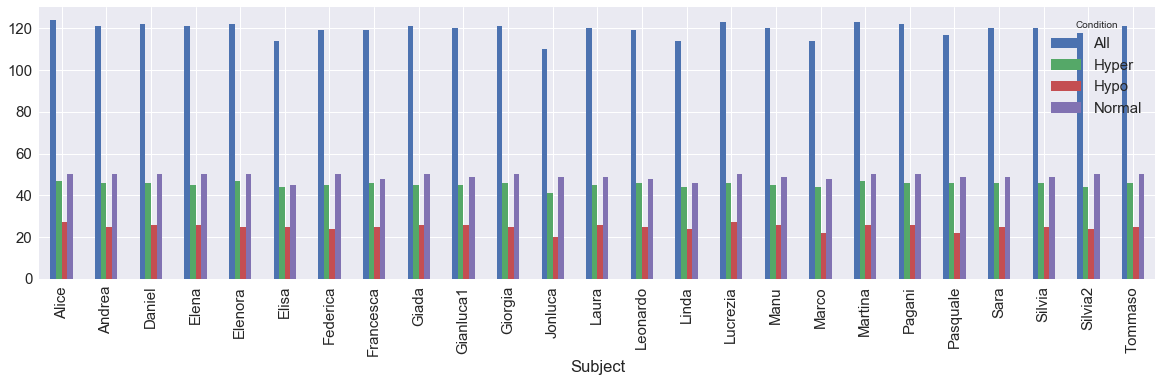

In [3]:
condition = ['Hyper','Normal','Hypo','All']
a=pd.DataFrame(data.loc['envelop','lipaparature',fr[0],condition,0,subject_name])
a=a.groupby(['Subject','Condition']).sum()['noTrials'].unstack().plot(kind='bar',figsize=(20,5),grid=True)

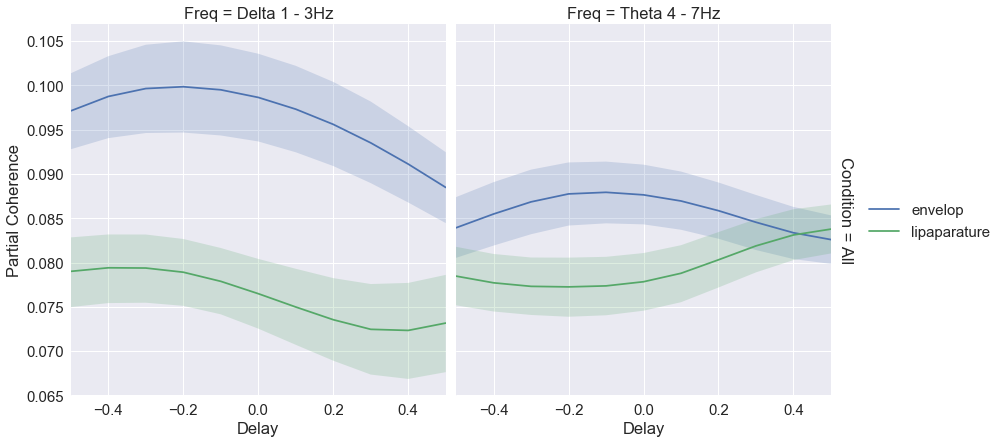

In [6]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop','lipaparature']

Removedfeatures = ['envelop','lipaparature']


condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

a = data.loc[features,Removedfeatures,freq_band,condition,delay,subject_name]['partialCoh']
a = pd.DataFrame(a.reset_index())

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value="partialCoh",color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Partial Coherence')

In [7]:
a.head()

,Feature,RemovedFeature,Freq,Condition,Delay,Subject,partialCoh
0,envelop,lipaparature,Delta 1 - 3Hz,All,-0.5,Alice,0.125086
1,envelop,lipaparature,Delta 1 - 3Hz,All,-0.5,Andrea,0.097037
2,envelop,lipaparature,Delta 1 - 3Hz,All,-0.5,Daniel,0.135585
3,envelop,lipaparature,Delta 1 - 3Hz,All,-0.5,Elena,0.065420
4,envelop,lipaparature,Delta 1 - 3Hz,All,-0.5,Elenora,0.078236


In [ ]:
def get_coherence_value_delay(data,name,subject_name,delay,condition): 
    D = []
    D_std = []
    for d in delay:
        A = []
        B=[]
        for c in condition:
            a  = data.loc[name[0],name[1],c,d,subject_name].as_matrix().mean(axis=0)
            A.append(a[0].mean())
            B.append(a[0].std())

        D.append(A)
        D_std.append(B)
        
    D=np.asarray(D)
    D_std=np.asarray(D_std)
    
    frames=[]
    frames1=[]
    for c in range(0,len(condition)):
        frames.append(pd.DataFrame({condition[c]:D[:,c]}))
        frames1.append(pd.DataFrame({condition[c]:D_std[:,c]}))
        
    df=pd.concat((frames),axis=1)
    df.index = delay
    df.index.name = 'Delay'
    
    df_std=pd.concat((frames1),axis=1)
    df_std.index = delay
    df_std.index.name = 'Delay'
    return df,df_std

def get_coherence_value(data,name,subject_name,d,condition):
    x=[]
    for i in condition:
        a  = data.loc[name[0],name[1],name[2],i,d,subject_name].as_matrix().mean(axis=0)
        x.append(a[0])

    return x

def plot_coherence(data,vmax,vmin,axes,name,info): 
    im = mne.viz.plot_topomap(data, info.info, axes=axes, show=False,vmin=vmin,vmax=vmax)
    axes.set(title=name)
    return im

def plot_coherence_preprocess(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(condition),figsize=(10,4))
    for i in range(0,len(condition)):
        im = plot_coherence(x[i],vmax,vmin,axes[i],condition[i],info)

    fig.suptitle(name[0]+'-Delay-'+ str(delay)+ '-'+name[1])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.04, 0.3])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    
def plot_coherence_preprocess_delay(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(delay),figsize=(20,6))
    for i in range(0,len(delay)):
        im = plot_coherence(x[i][0],vmax,vmin,axes[i],delay[i],info)

    fig.suptitle(name[0]+ ' -Removed-'+name[1]+' - '+name[2]+'-'+ str(condition[0]),y=0.7)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.50, 0.01, 0.15])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    return fig
    

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

#freq_band = ['fr 3 - 5Hz']
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['lipaparature']

Removedfeatures = ['envelop']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10


for f in freq_band:
    A = []
    for feat in features:
        name = (feat,Removedfeatures[0],f)
        for d in delay:
            a = get_coherence_value(data,name,subject_name,d,condition)
            A.append(a)
    a = plot_coherence_preprocess_delay(A,name,condition,delay,info)
    
